#### 1. Cel Projektu: 
Celem projektu będzie zastosowanie sieci neuronowych do predykcji długości dróg rowerowych na 100 km² na podstawie wybranych cech, takich jak tereny zielone, stopa bezrobocia czy dochody budżetowe. Wyniki sieci neuronowej zostaną porównane z wynikami modelu regresji liniowej i lasu losowego.
W ramach projektu przeprowadzono analizę deskryptywną, przygotowanie danych (m.in. uzupełnianie braków, usuwanie wartości odstających, skalowanie) oraz trening trzech modeli:

- Sieć neuronowa (Keras/TensorFlow),
- Regresja liniowa,
- Las losowy (RandomForestRegressor).

Celem było zidentyfikowanie, które podejście najlepiej przewiduje wartość „Drogi rowerowe na 100 km²” oraz jak poszczególne cechy wpływają na te predykcje.

#### 2. Opis danych

Dane pochodzą z plików .csv i plików .shp (shapefile) opisujących powiaty w Polsce ze strony https://portal.geo.stat.gov.pl/. 
Każdy zbiór danych posiada kolumnę z identyfikatorem TERYT, którą sformatowano do postaci czterocyfrowej (np. str.zfill(4)). Dzięki temu można było wykonać poprawne łączenie danych.

#### 3. Metodologia

##### Import i wstępne przetwarzanie

Wczytano shapefile do obiektów geopandas (powiaty) i kilka plików CSV (np. bezrobocie, tereny zieleni, wynagrodzenia, mediana wieku, budżet).
Ujednolicono format klucza TERYT, usunięto niepotrzebne kolumny.

In [1]:
#import bibliotek

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization # type: ignore
import scipy.stats as stats # type: ignore
from scipy.stats import shapiro # type: ignore
from scipy.stats import ttest_rel
from scikeras.wrappers import KerasRegressor # type: ignore
import shap


C:\Users\ozime\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#import danych
powiaty = gpd.read_file('sieci_neuronowe_blicharska_ozimek/powiaty.shp')
drogi = pd.read_csv('sieci_neuronowe_blicharska_ozimek/tabela_powiaty.csv') #zmienna objaśniana
bezrobocie = pd.read_csv('sieci_neuronowe_blicharska_ozimek/stopa_bezrobocia.csv')
tereny = pd.read_csv('sieci_neuronowe_blicharska_ozimek/tereny_zieleni.csv')
wynagrodzenia = pd.read_csv('sieci_neuronowe_blicharska_ozimek/miesieczne_wynagrodzenia.csv')
mediana_wieku = pd.read_csv('sieci_neuronowe_blicharska_ozimek/mediana wieku według płci.csv')
budzet = pd.read_csv('sieci_neuronowe_blicharska_ozimek/dochody_powiat.csv')

Każdy zbiór danych posiada kolumnę z identyfikatorem TERYT, którą sformatowano do postaci czterocyfrowej (np. str.zfill(4)). Dzięki temu można było wykonać poprawne łączenie danych.

In [3]:
#Format kolumn
powiaty['JPT_KOD_JE'] = powiaty['JPT_KOD_JE'].astype(str).str.zfill(4)
drogi['TERYT'] = drogi['TERYT'].astype(str).str.zfill(4)
bezrobocie['TERYT'] = bezrobocie['TERYT'].astype(str).str.zfill(4)
tereny['TERYT'] = tereny['TERYT'].astype(str).str.zfill(4)
wynagrodzenia['TERYT'] = wynagrodzenia['TERYT'].astype(str).str.zfill(4)
mediana_wieku['TERYT'] = mediana_wieku['TERYT'].astype(str).str.zfill(4)
budzet['TERYT'] = budzet['TERYT'].astype(str).str.zfill(4)

In [4]:
#Łączenie danych
dane = powiaty.merge(drogi, left_on="JPT_KOD_JE", right_on="TERYT", how="left") \
              .merge(bezrobocie[['TERYT', 'Stopa bezrobocia rejestrowanego|ogółem']], on='TERYT', how='left')\
              .merge(tereny[['TERYT', 'Tereny zieleni|parki spacerowo - wypoczynkowe|powierzchnia|ogółem (w miastach i na wsi)']], on='TERYT', how='left')\
              .merge(wynagrodzenia[['TERYT', 'Przeciętne miesięczne wynagrodzenia brutto|ogółem']], on='TERYT', how='left')\
              .merge(mediana_wieku[['TERYT', 'Mediana wieku ludności według płci|ogółem']], on='TERYT', how='left')\
              .merge(budzet[['TERYT', 'Dochody budżetów powiatów|ogółem']], on='TERYT', how='left')

#usuwanie niepotrzebnych kolumn
dane = dane.drop(['gml_id','JPT_SJR_KO','JPT_POWIER','JPT_ORGAN_', 'JPT_JOR_ID', 'WERSJA_OD', 'WERSJA_DO', 'WAZNY_OD','rok',
       'WAZNY_DO', 'JPT_KOD__1', 'JPT_NAZWA1', 'JPT_ORGAN1', 'JPT_WAZNA_', 'TERYT województwa', 'Województwo',
       'ID_BUFORA_', 'ID_BUFORA1', 'ID_TECHNIC', 'IIP_PRZEST', 'IIP_IDENTY',
       'IIP_WERSJA', 'JPT_KJ_IIP', 'JPT_KJ_I_1', 'JPT_KJ_I_2', 'JPT_OPIS',
       'JPT_SPS_KO', 'ID_BUFOR_1', 'JPT_ID', 'JPT_POWI_1', 'JPT_KJ_I_3',
       'JPT_GEOMET', 'JPT_GEOM_1', 'SHAPE_LENG', 'SHAPE_AREA', 'REGON',
       'RODZAJ', 'oid', 'kod KTS','Typ powiatu'], axis=1)

In [5]:
#uproszczenie nazw kolumn
dane = dane.rename(columns={
    'Długość dróg dla rowerów|drogi dla rowerów na 100 km2': 'Drogi rowerowe na 100 km2',
    'Stopa bezrobocia rejestrowanego|ogółem': 'Stopa bezrobocia',
    'Tereny zieleni|parki spacerowo - wypoczynkowe|powierzchnia|ogółem (w miastach i na wsi)': 'Tereny zieleni',
    'Przeciętne miesięczne wynagrodzenia brutto|ogółem': 'Przeciętne wynagrodzenia brutto',
    'Mediana wieku ludności według płci|ogółem': 'Mediana wieku',
    'Dochody budżetów powiatów|ogółem': 'Dochody budżetów powiatów'
})

print(dane.columns)

Index(['JPT_KOD_JE', 'JPT_NAZWA_', 'geometry', 'powiat', 'powierzchnia',
       'TERYT', 'Drogi rowerowe na 100 km2', 'Stopa bezrobocia',
       'Tereny zieleni', 'Przeciętne wynagrodzenia brutto', 'Mediana wieku',
       'Dochody budżetów powiatów'],
      dtype='object')


##### Wizualizacja zmiennych na mapie.

Text(0.5, 1.0, 'Długość dróg dla rowerów na 100 km2')

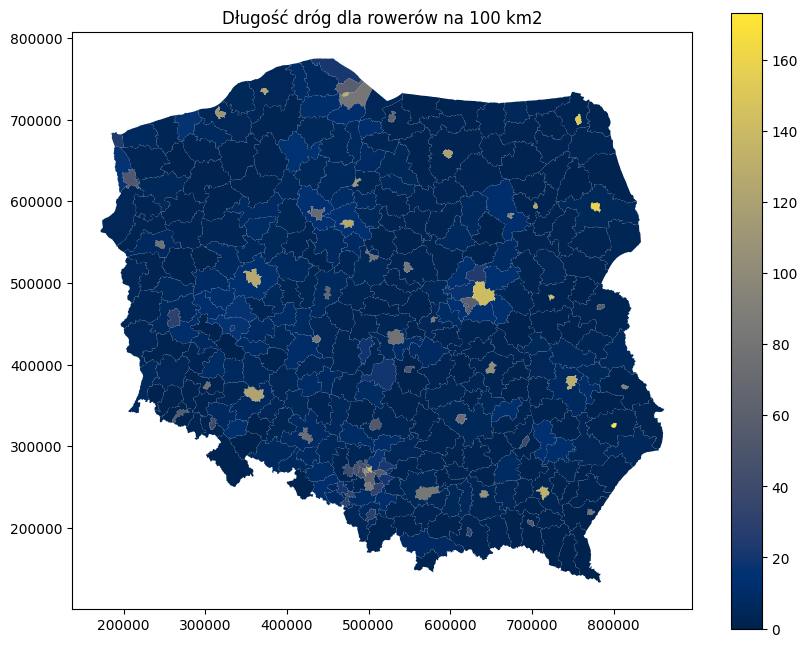

In [6]:
#Wizualizacja długości dróg dla rowerowych na 100km2 według powiatów
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
dane.plot(column="Drogi rowerowe na 100 km2", 
          legend=True, cmap="cividis", ax=ax)
plt.title("Długość dróg dla rowerów na 100 km2")

Text(0.5, 1.0, 'Stopa bezrobocia ogółem')

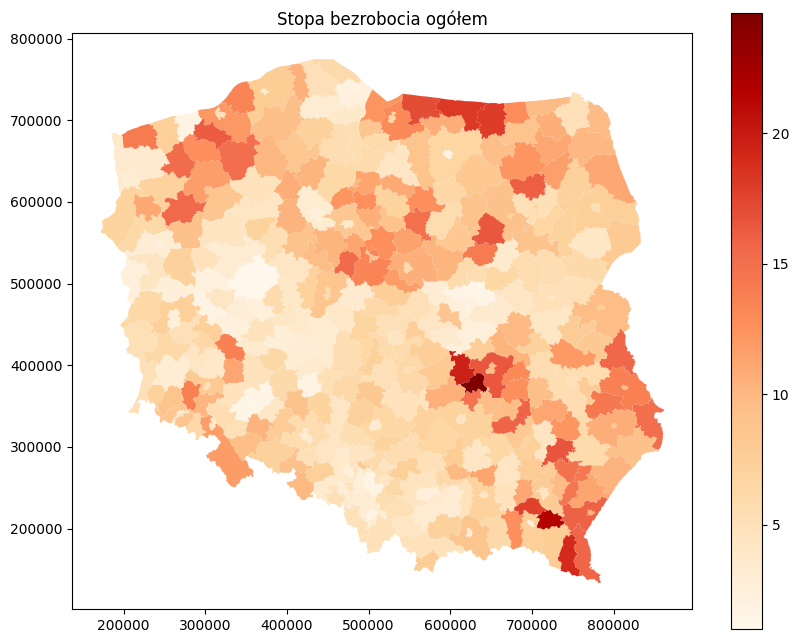

In [7]:
#Wizualizacja stopy bezrobocia według powiatów
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
dane.plot(column="Stopa bezrobocia", 
          legend=True, cmap="OrRd", ax=ax)
plt.title("Stopa bezrobocia ogółem")

Text(0.5, 1.0, 'Tereny zieleni (miasto i wieś)')

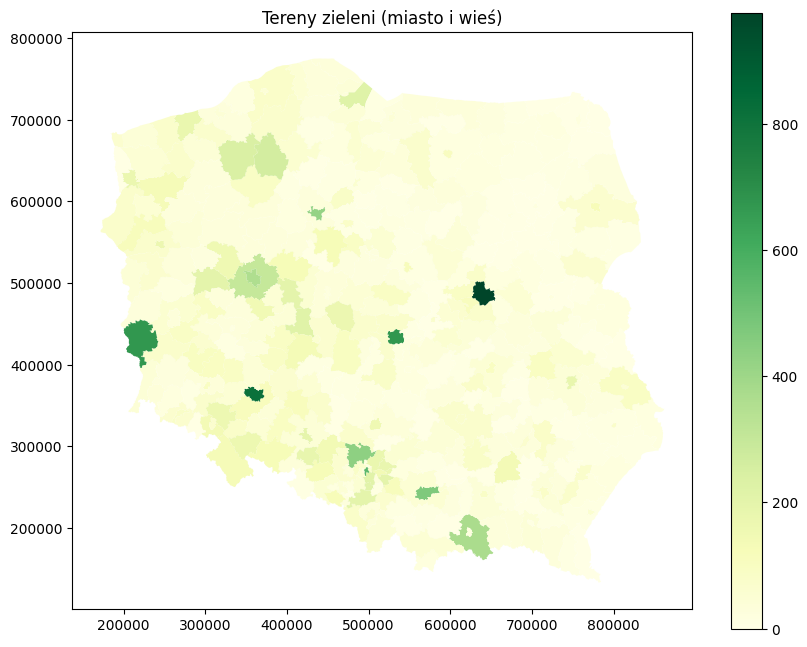

In [8]:
#Wizualizacja terenów zielonych według powiatów
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
dane.plot(column="Tereny zieleni", 
          legend=True, cmap="YlGn", ax=ax)
plt.title("Tereny zieleni (miasto i wieś)")

Text(0.5, 1.0, 'Mediana wieku')

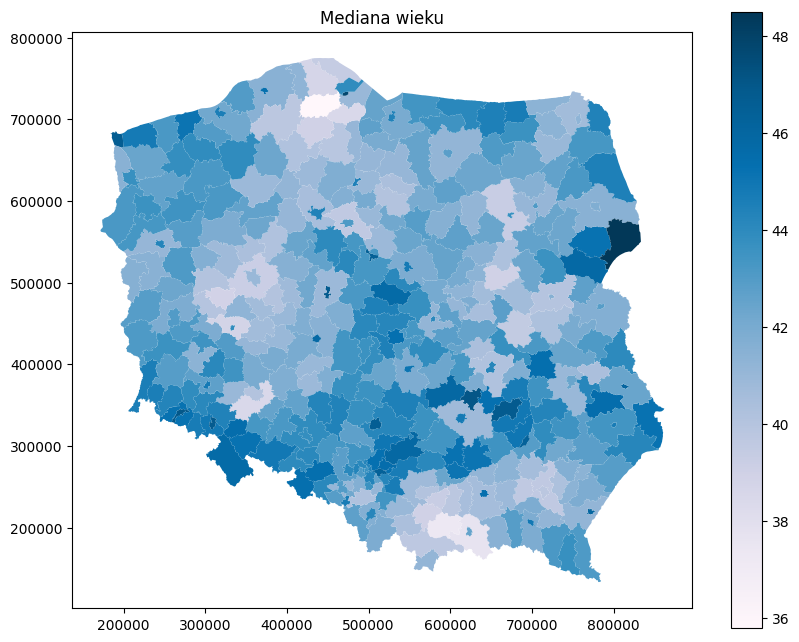

In [9]:
#Wizualizacja mediany wieku według powiatów
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
dane.plot(column="Mediana wieku", 
          legend=True, cmap="PuBu", ax=ax)
plt.title("Mediana wieku")

Text(0.5, 1.0, 'Przeciętne wynagrodzenia brutto')

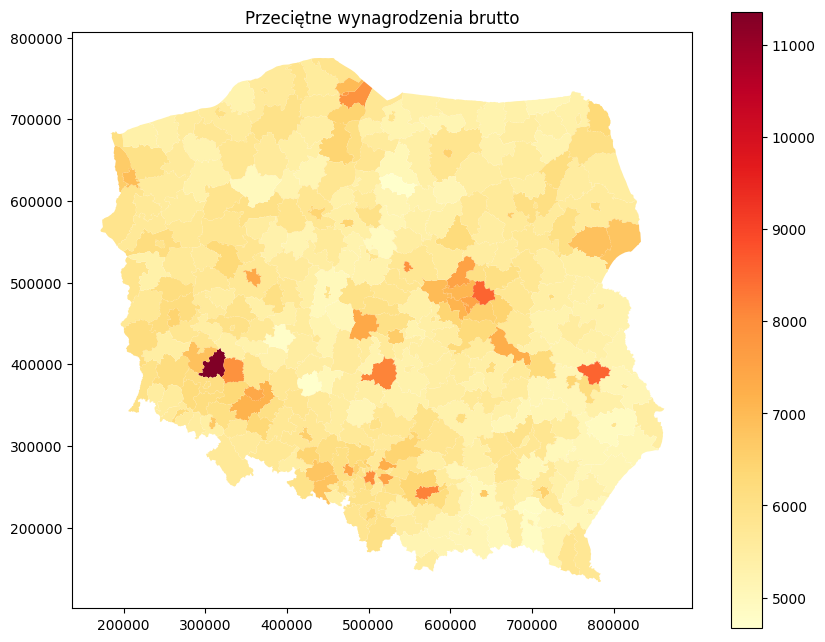

In [10]:
#Wizualizacja przeciętnego wynagrodzenia brutto według powiatów
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
dane.plot(column="Przeciętne wynagrodzenia brutto", 
          legend=True, cmap="YlOrRd", ax=ax)
plt.title("Przeciętne wynagrodzenia brutto")

Text(0.5, 1.0, 'Dochody budżetów powiatów')

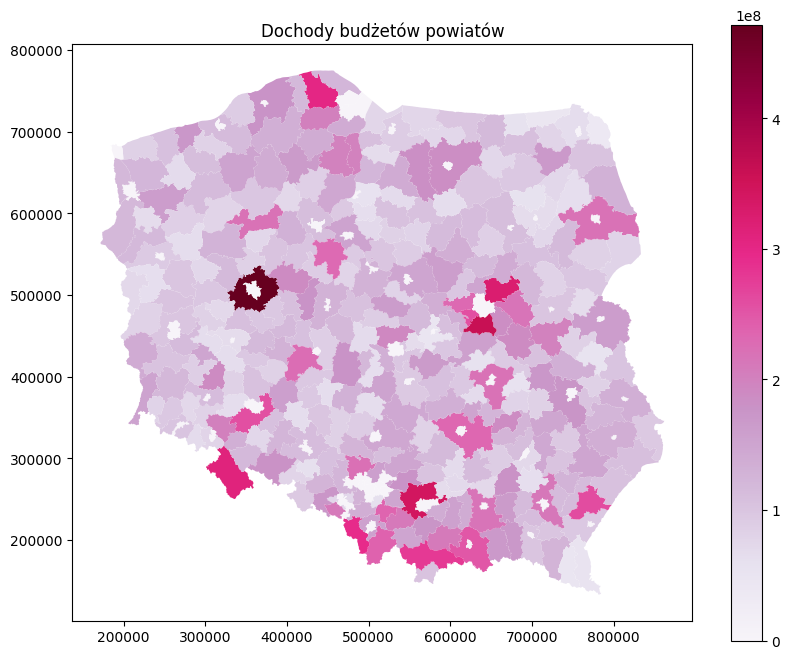

In [11]:
#Wizualizacja dochodów budżetów powiatów według powiatów
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
dane.plot(column="Dochody budżetów powiatów", 
          legend=True, cmap="PuRd", ax=ax)
plt.title("Dochody budżetów powiatów")

In [12]:
#wybranie kolumn
selected_columns = [
    'Drogi rowerowe na 100 km2',
    'Stopa bezrobocia',
    'Tereny zieleni',
    'Przeciętne wynagrodzenia brutto',
    'Mediana wieku',
    'Dochody budżetów powiatów'
]

##### Analiza deskryptywna i przygotowanie danych

- Usunięto lub zastąpiono brakujące wartości (metodą mediany).
- Wykryto wartości odstające za pomocą IQR i zastąpiono je medianą.
- Sprawdzono rozkład cech (histogramy, test Shapiro-Wilka, QQ-plot).
- Zbadano korelacje (heatmapa), aby zobaczyć, które zmienne najsilniej korelują ze zmienną docelową oraz między sobą.
- Przeprowadzono skalowanie cech (StandardScaler).

In [56]:
df_selected = dane[selected_columns].copy()
print("Braki danych:\n", df_selected.isnull().sum())

Braki danych:
 Drogi rowerowe na 100 km2          0
Stopa bezrobocia                   0
Tereny zieleni                     0
Przeciętne wynagrodzenia brutto    1
Mediana wieku                      0
Dochody budżetów powiatów          0
dtype: int64


In [57]:
df_selected.fillna(df_selected.median(), inplace=True)

# Sprawdzanie ponownie braków
print("Braki danych po uzupełnieniu:\n", df_selected.isnull().sum())

Braki danych po uzupełnieniu:
 Drogi rowerowe na 100 km2          0
Stopa bezrobocia                   0
Tereny zieleni                     0
Przeciętne wynagrodzenia brutto    0
Mediana wieku                      0
Dochody budżetów powiatów          0
dtype: int64


In [58]:
df_selected.info()
df_selected.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Drogi rowerowe na 100 km2        380 non-null    float64
 1   Stopa bezrobocia                 380 non-null    float64
 2   Tereny zieleni                   380 non-null    float64
 3   Przeciętne wynagrodzenia brutto  380 non-null    float64
 4   Mediana wieku                    380 non-null    float64
 5   Dochody budżetów powiatów        380 non-null    float64
dtypes: float64(6)
memory usage: 17.9 KB


,Drogi rowerowe na 100 km2,Stopa bezrobocia,Tereny zieleni,Przeciętne wynagrodzenia brutto,Mediana wieku,Dochody budżetów powiatów
163,3.57,4.5,436.87,6218.12,43.5,2.218232e+08
334,0.50,17.7,4.00,4831.84,41.9,1.135940e+08
272,0.42,15.2,75.19,5630.58,43.8,6.894445e+07
120,160.97,5.2,125.57,6183.98,41.8,0.000000e+00
55,5.54,4.7,10.69,5127.71,40.5,1.383953e+08


In [59]:
df_selected.describe()

,Drogi rowerowe na 100 km2,Stopa bezrobocia,Tereny zieleni,Przeciętne wynagrodzenia brutto,Mediana wieku,Dochody budżetów powiatów
count,380.000000,380.000000,380.000000,380.000000,380.000000,3.800000e+02
mean,17.844342,7.263684,64.883789,5817.842684,42.703421,1.026854e+08
std,32.820855,3.994963,102.954056,686.944656,1.885891,7.042335e+07
min,0.000000,1.000000,0.000000,4668.600000,35.800000,0.000000e+00
25%,2.272500,4.400000,15.775000,5410.520000,41.300000,6.677774e+07
50%,4.495000,6.350000,33.300000,5670.310000,42.700000,1.008792e+08
75%,11.390000,9.600000,73.540000,6027.147500,44.100000,1.358139e+08
max,173.430000,24.600000,977.030000,11361.510000,48.500000,4.718877e+08


Test Shapiro-Wilka dla Drogi rowerowe na 100 km2: Stat=0.5532051984519204, p-value=5.580672180077546e-30
  Dane dla Drogi rowerowe na 100 km2 nie mają rozkładu normalnego (Odrzucona hipoteza zerowa).
Test Shapiro-Wilka dla Stopa bezrobocia: Stat=0.934345663987481, p-value=6.805068497140191e-12
  Dane dla Stopa bezrobocia nie mają rozkładu normalnego (Odrzucona hipoteza zerowa).
Test Shapiro-Wilka dla Tereny zieleni: Stat=0.5210420285708429, p-value=8.390147021086334e-31
  Dane dla Tereny zieleni nie mają rozkładu normalnego (Odrzucona hipoteza zerowa).
Test Shapiro-Wilka dla Przeciętne wynagrodzenia brutto: Stat=0.8131066050460266, p-value=1.249032304821782e-20
  Dane dla Przeciętne wynagrodzenia brutto nie mają rozkładu normalnego (Odrzucona hipoteza zerowa).
Test Shapiro-Wilka dla Mediana wieku: Stat=0.9974230093805265, p-value=0.8222070879560704
  Dane dla Mediana wieku mają rozkład normalny (brak podstaw do odrzucenia hipotey zerowej).
Test Shapiro-Wilka dla Dochody budżetów powiat

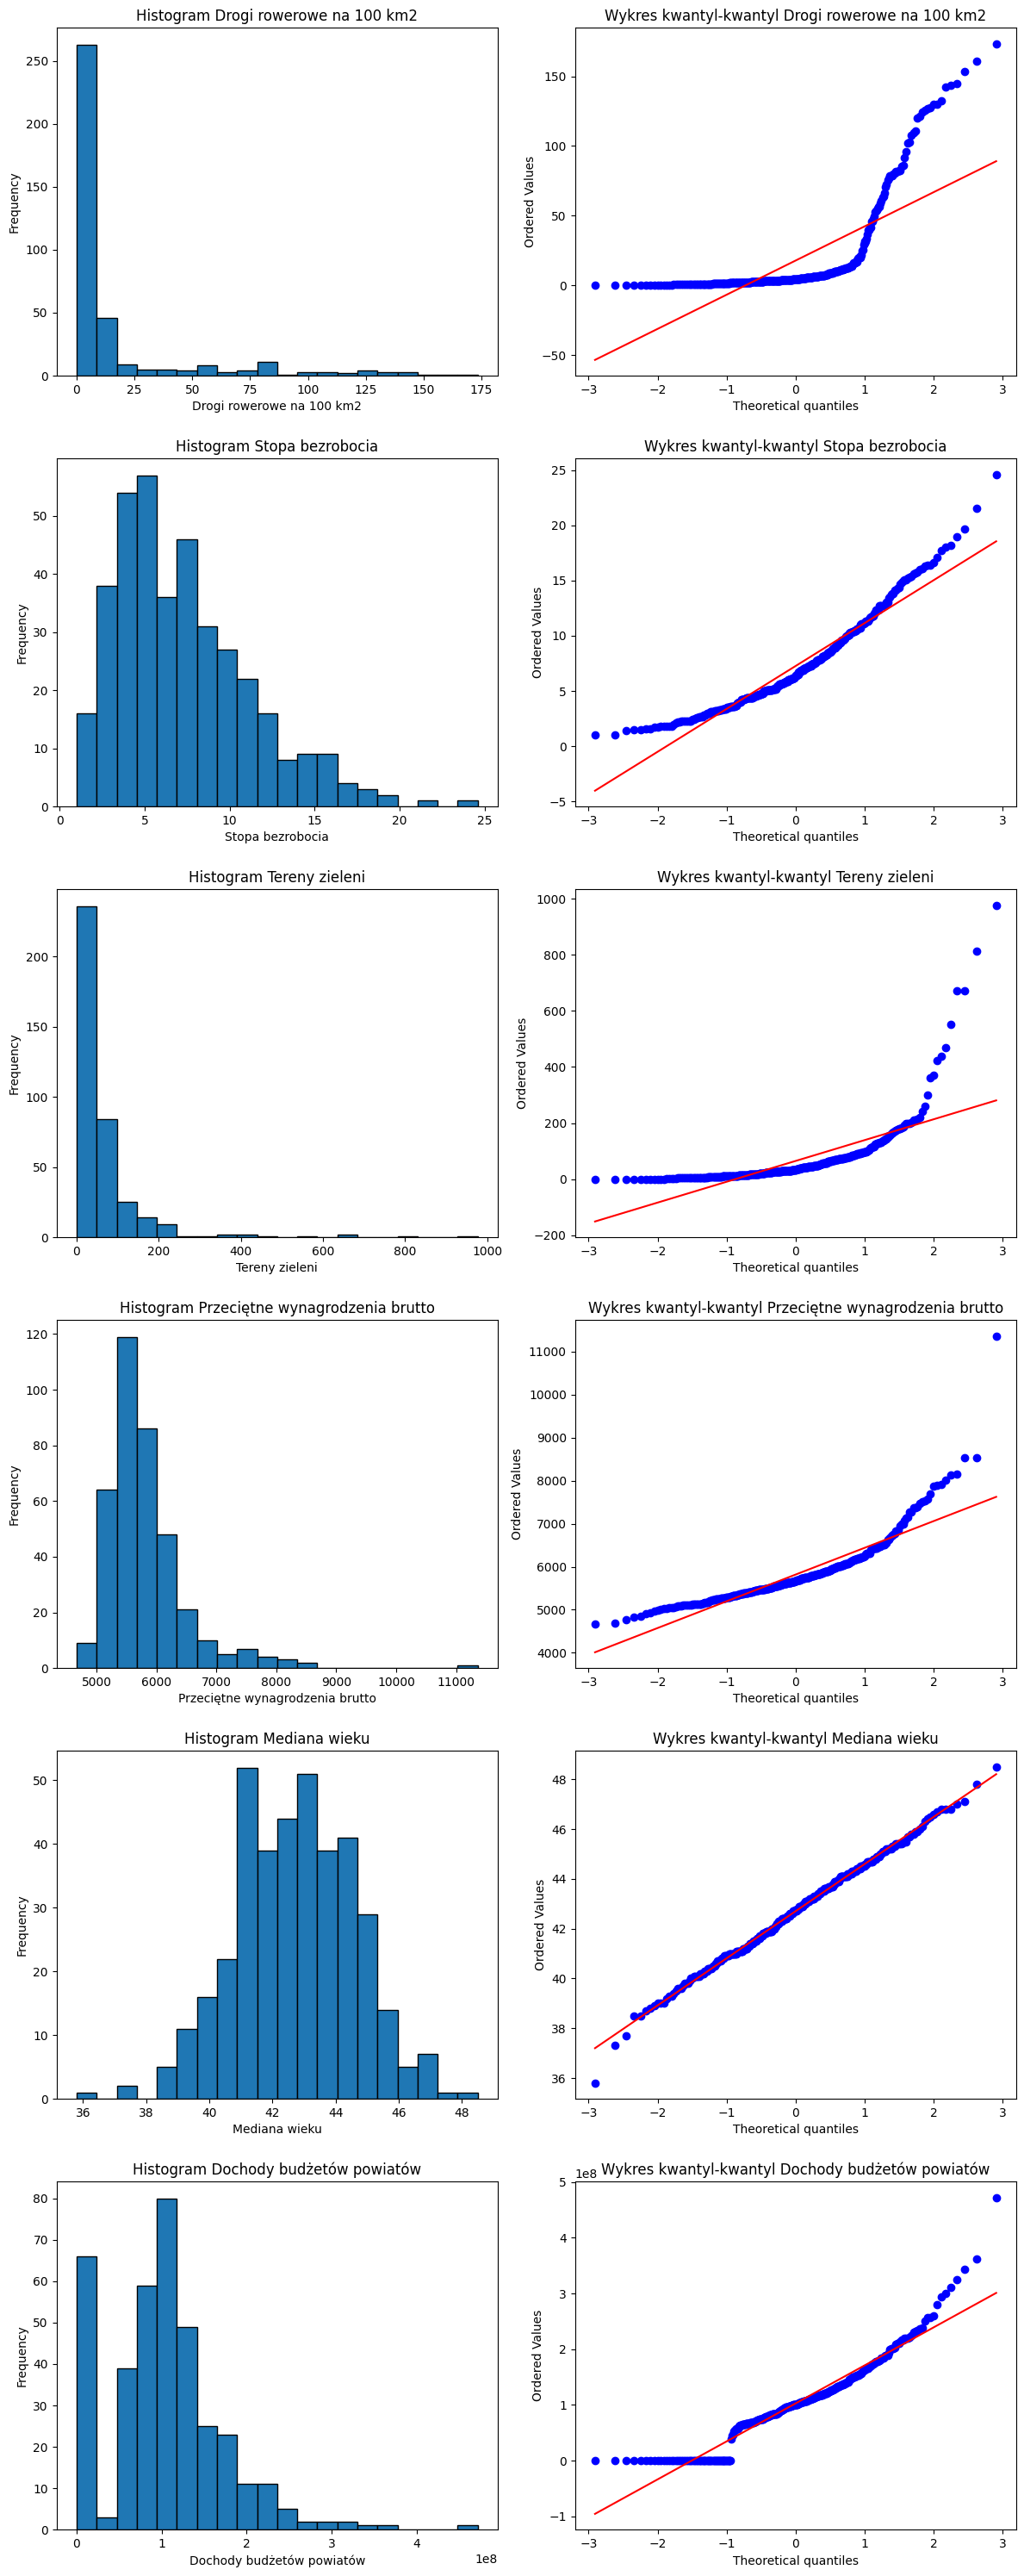

In [60]:
# Test Shapiro - Wilka
fig, axes = plt.subplots(len(selected_columns), 2, figsize=(12, len(selected_columns) * 5))

for i, col in enumerate(selected_columns):
    # Histogram
    axes[i, 0].hist(dane[col].dropna(), bins=20, edgecolor='black')
    axes[i, 0].set_title(f'Histogram {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')
    
    # Q-Q wykres
    stats.probplot(dane[col].dropna(), dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'Wykres kwantyl-kwantyl {col}')
    
    # Test Shapiro-Wilka
    stat, p_value = shapiro(dane[col].dropna())
    print(f'Test Shapiro-Wilka dla {col}: Stat={stat}, p-value={p_value}')
    if p_value < 0.05:
        print(f"  Dane dla {col} nie mają rozkładu normalnego (Odrzucona hipoteza zerowa).")
    else:
        print(f"  Dane dla {col} mają rozkład normalny (brak podstaw do odrzucenia hipotey zerowej).")

plt.tight_layout()
plt.show()

##### Analiza rozkładów i test Shapiro–Wilka

W celu sprawdzenia, czy rozkłady zmiennych są zbliżone do normalnych, zastosowano test Shapiro–Wilka (poziom istotności α=0,05). Dodatkowo wygenerowano histogramy i wykresy kwantyl-kwantyl (Q-Q):

Drogi rowerowe na 100 km²
- Histogram wykazuje silne skupienie przy wartościach bliskich 0 i długi prawy ogon – dane są wyraźnie prawoskośne.
- Q-Q plot odchodzi od linii prostej w prawo (wartości znacznie przekraczające teoretyczne kwantyle).
- Test Shapiro–Wilka: p-value = 5.58e-30 < 0.05 → odrzucono hipotezę o normalności rozkładu.

Stopa bezrobocia
- Histogram jest bardziej rozszerzony, ale wciąż skośny, z długim prawym ogonem (sięga nawet do ~20%).
- Q-Q plot pokazuje odchylenia w ogonie.
- Test Shapiro–Wilka: p-value = 6.80e-12 < 0.05 → rozkład nienormalny.

Tereny zieleni
- Histogram silnie prawoskośny, większość wartości jest niska, a nieliczne obserwacje przy wysokich wartościach (nawet do 1000).
- Q-Q plot – duże odchylenia w końcówce (prawym ogonie).
- Test: p-value = 8.39e-31 < 0.05 → odrzucenie hipotezy o normalności.

Przeciętne wynagrodzenia brutto
- Histogram dość zbliżony do rozkładu asymetrycznego (umiarkowanie prawoskośny), główny peak między 5000–6000.
- Q-Q plot – widać większe odchylenia w prawym ogonie.
- Test: p-value = 1.249e-20 < 0.05 → nienormalny rozkład.

Mediana wieku
- Histogram jest rozłożony między ~36 a 48, z wyraźnym „szczytem” około 40–44 lat.
- Q-Q plot dopasowuje się do linii niemal idealnie.
- Test: p-value = 0.8222 > 0.05 → brak podstaw do odrzucenia normalności (ta zmienna może być uznana za ~normalną).

Dochody budżetów powiatów
- Histogram prawoskośny, większość obserwacji w niższych przedziałach, kilka wartości bardzo wysokich (prawy ogon).
- Q-Q plot ujawnia spore odchylenie w prawym ogonie.
- Test: p-value = 1.73e-12 < 0.05 → nienormalny rozkład.

Wnioski: Wyniki testu i obserwacje z histogramów i Q-Q plotów sugerują, że dane w większości wymagają metod niewymagających założeń normalności, dlatego też nie ma żadnych przeszkód aby użyc np. modele maszynowe, sieć neuronowa.

In [61]:
# Podział na cechy (X) i zmienną docelową (y)
X = df_selected.drop(columns=['Drogi rowerowe na 100 km2'])
y = df_selected['Drogi rowerowe na 100 km2']

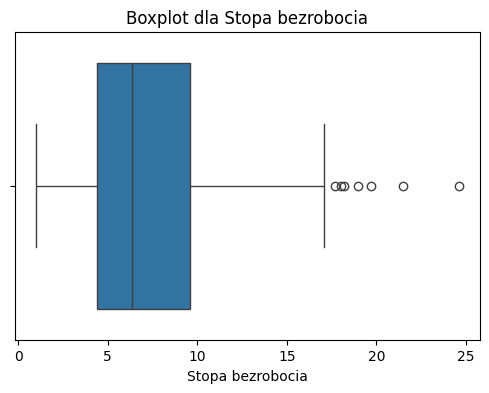

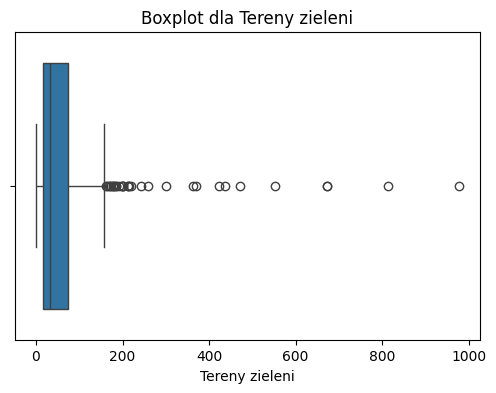

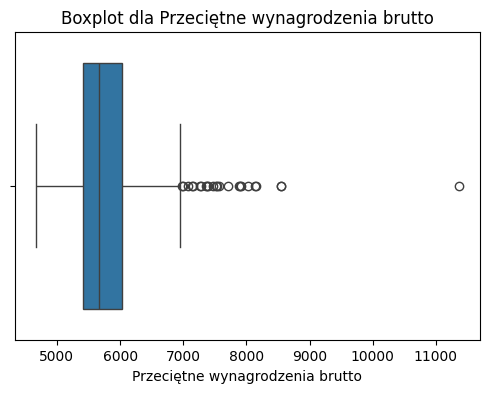

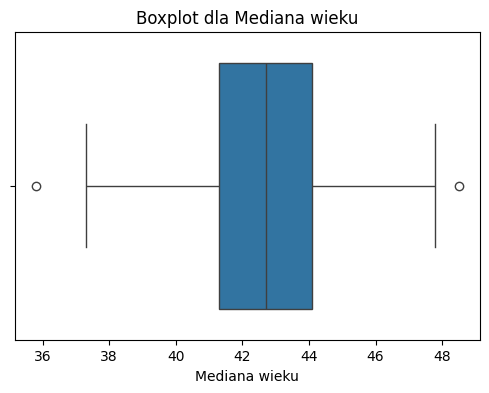

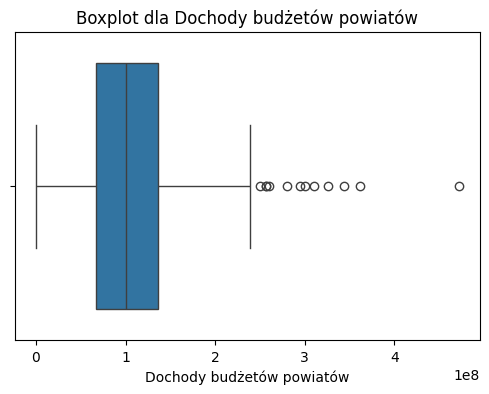

In [62]:
# Wizualizacja boxplot dla zmiennych wejściowych
for col in X.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=X[col])
    plt.title(f"Boxplot dla {col}")
    plt.show()

In [63]:
# Wykrywanie wartości odstających za pomocą IQR
for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = X[(X[col] < lower_bound) | (X[col] > upper_bound)]
    print(f"Znaleziono {len(outliers)} wartości odstających w kolumnie {col}")


Znaleziono 7 wartości odstających w kolumnie Stopa bezrobocia
Znaleziono 32 wartości odstających w kolumnie Tereny zieleni
Znaleziono 24 wartości odstających w kolumnie Przeciętne wynagrodzenia brutto
Znaleziono 2 wartości odstających w kolumnie Mediana wieku
Znaleziono 12 wartości odstających w kolumnie Dochody budżetów powiatów


Aby złagodzić wpływ skrajnych obserwacji na trenowane modele (zwłaszcza modele wrażliwe na outliery, takie jak sieci neuronowe czy regresja liniowa), zdecydowano się zastąpić wartości odstające medianą w każdej z kolumn. Dzięki temu zredukowano wpływ ekstremalnych obserwacji przy zachowaniu reprezentatywności reszty danych.

In [64]:
# Zastępowanie wartości odstających medianą w każdej kolumnie
for col in X.columns:
    Q1 = X[col].quantile(0.25)  # Pierwszy kwartyl
    Q3 = X[col].quantile(0.75)  # Trzeci kwartyl
    IQR = Q3 - Q1  # Rozstęp międzykwartylowy
    lower_bound = Q1 - 1.5 * IQR  # Dolna granica
    upper_bound = Q3 + 1.5 * IQR  # Górna granica
    
    # Znajdź wartości odstające i zastąp je medianą
    X[col] = X[col].apply(lambda x: X[col].median() if x < lower_bound or x > upper_bound else x)


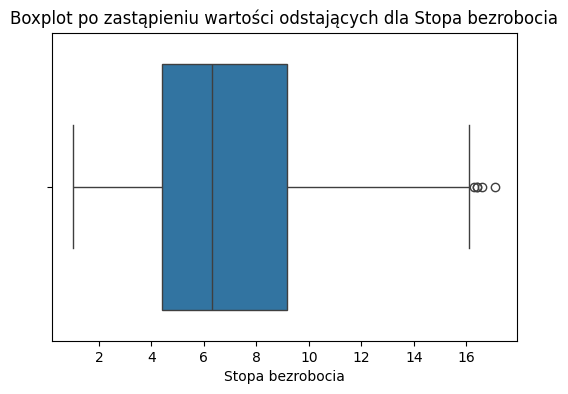

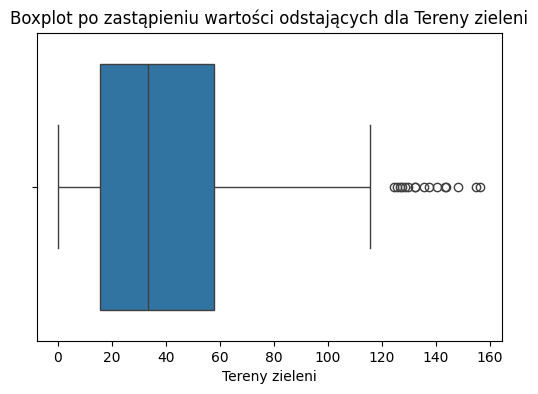

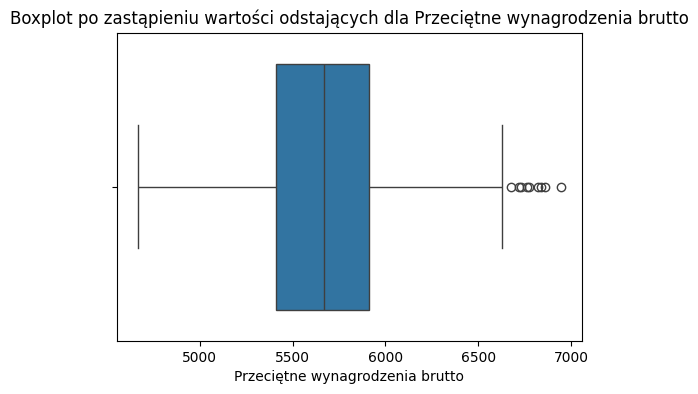

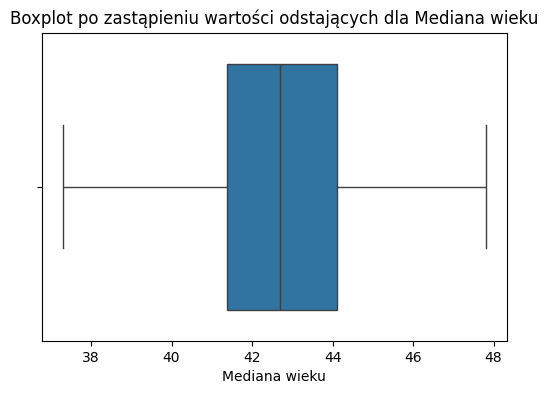

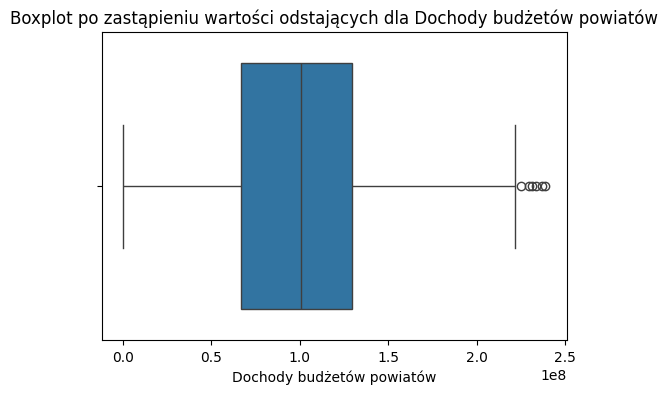

In [65]:
# Wizualizacja boxplot po zastąpieniu wartości odstających
for col in X.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=X[col])
    plt.title(f"Boxplot po zastąpieniu wartości odstających dla {col}")
    plt.show()


Po zastąpieniu wartości odstajacych medianą można zauważyć, że wykresy pudełkowe Boxplot są bardziej wyrównane.

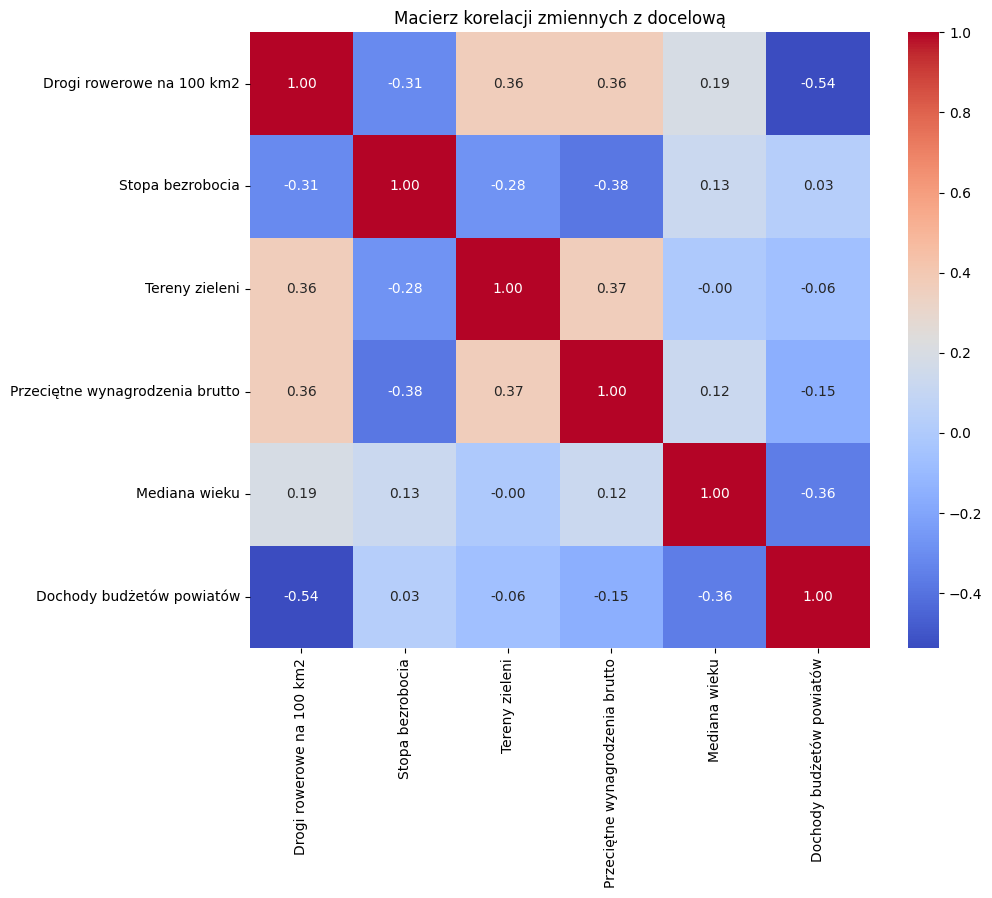

In [66]:
# Macierz korelacji z wyróżnieniem zmiennej docelowej
correlation_matrix = df_selected.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Macierz korelacji zmiennych z docelową")
plt.show()

In [67]:
# Obliczenie macierzy korelacji
correlation_matrix = X.corr()

# Sprawdzenie zmiennych z wysoką korelacją
threshold = 0.9  # Ustal próg kolinearności
high_corr = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix != 1.0)]
print("Zmienne z wysoką korelacją:\n", high_corr.dropna(how='all'))

Zmienne z wysoką korelacją:
 Empty DataFrame
Columns: [Stopa bezrobocia, Tereny zieleni, Przeciętne wynagrodzenia brutto, Mediana wieku, Dochody budżetów powiatów]
Index: []


In [68]:
max_corr_values = df_selected.corr()['Drogi rowerowe na 100 km2'].abs().drop('Drogi rowerowe na 100 km2').nlargest(4)
max_corr_indices = max_corr_values.index

In [69]:
print(f"Największe korelacje ze zmienną 'Drogi rowerowe na 100 km2':")
for idx in max_corr_indices:
    max_corr_value = df_selected.corr()['Drogi rowerowe na 100 km2'][idx]
    print(f"{idx}: {max_corr_value:.2f}")

Największe korelacje ze zmienną 'Drogi rowerowe na 100 km2':
Dochody budżetów powiatów: -0.54
Tereny zieleni: 0.36
Przeciętne wynagrodzenia brutto: 0.36
Stopa bezrobocia: -0.31


In [72]:
min_corr_values = df_selected.corr()['Drogi rowerowe na 100 km2'].abs().drop('Drogi rowerowe na 100 km2').nsmallest(4)
min_corr_indices = min_corr_values.index

In [73]:
print(f"Najmniejsze korelacje ze zmienną 'Drogi rowerowe na 100 km2':")
for idx in min_corr_indices:
    min_corr_value = df_selected.corr()['Drogi rowerowe na 100 km2'][idx]
    print(f"{idx}: {min_corr_value:.2f}")

Najmniejsze korelacje ze zmienną 'Drogi rowerowe na 100 km2':
Mediana wieku: 0.19
Stopa bezrobocia: -0.31
Przeciętne wynagrodzenia brutto: 0.36
Tereny zieleni: 0.36


##### Wnioski dla macierzy korelacji:

Drogi rowerowe a Dochody budżetów powiatów: Korelacja ujemna -0.54.
- Sugeruje to, że powiaty o wyższych dochodach budżetowych mają raczej niższe wartości dróg rowerowych na 100 km², co może wydawac się nieintuicyjne. Warto przyjrzeć się dokładniej, czy w tych powiatach może istnieje inna specyfika (np. duża powierzchnia, a relatywnie mniej tras rowerowych).

Drogi rowerowe a Tereny zieleni: Korelacja dodatnia 0.36.
- Wskazuje to, że tam, gdzie jest więcej terenów zieleni, zwykle odnotowuje się wyższe wartości dróg rowerowych (co intuicyjnie może mieć sens, jeśli te powiaty stawiają na infrastrukturę rekreacyjną).

Drogi rowerowe a Przeciętne wynagrodzenia brutto: Korelacja dodatnia 0.36.
- Może to znaczyć, że powiaty o wyższych zarobkach mogą jednocześnie inwestować w infrastrukturę rowerową bądź występuje inna zmienna pośrednia.

Drogi rowerowe a Stopa bezrobocia: Korelacja ujemna -0.31.
- Wyższa stopa bezrobocia jest łagodnie powiązana z niższym wskaźnikiem dróg rowerowych. Może to być efekt niskiego poziomu inwestycji w danym regionie lub mniejszej atrakcyjności turystycznej/infrastrukturalnej.

Drogi rowerowe a Mediana wieku: Korelacja dodatnia 0.19 (raczej słaba).
- Nie wskazuje na silny związek – może być tak, że w powiatach z nieco wyższą medianą wieku jest odrobinę więcej tras rowerowych, choć zależność ta nie jest mocna.

Pozostałe korelacje między cechami:

- Stopa bezrobocia a Przeciętne wynagrodzenia (ok. –0.38) – obszary z wyższym bezrobociem często mają niższe wynagrodzenia, co jest dość intuicyjne.
- Mediana wieku a Dochody budżetów (–0.36) – w regionach z wyższą medianą wieku dochody budżetów powiatów bywają niższe.

Podsumowanie: 

Najsilniejszą korelacją ze zmienną docelową (Drogi rowerowe) są:
- Dochody budżetów (–0.54),
- Tereny zieleni (+0.36),
- Przeciętne wynagrodzenia (+0.36).

Te cechy mogą okazać się istotne podczas modelowania (przewidywania), ale nie należy wykluczać innych zmiennych - może wystąpić nieliniowy wpływ, którego korelacja nie pokazuje.
W dalszej analizie (modelach regresyjnych i sieci neuronowej) warto zwrócić uwagę, jak mocno te zmienne wpływają na końcową predykcję (m.in. potwierdzane za pomocą wyników SHAP).

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001281A05F560>
Traceback (most recent call last):
  File "c:\Program Files\Python311\Lib\weakref.py", line 370, in remove
    self = selfref()
           ^^^^^^^^^
KeyboardInterrupt: 


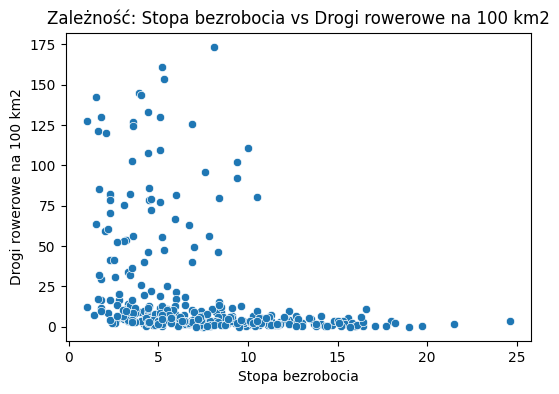

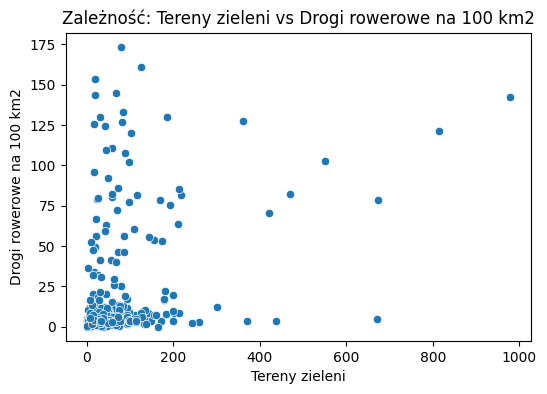

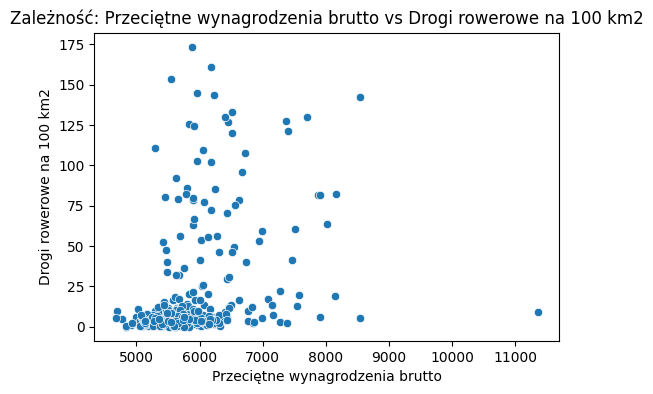

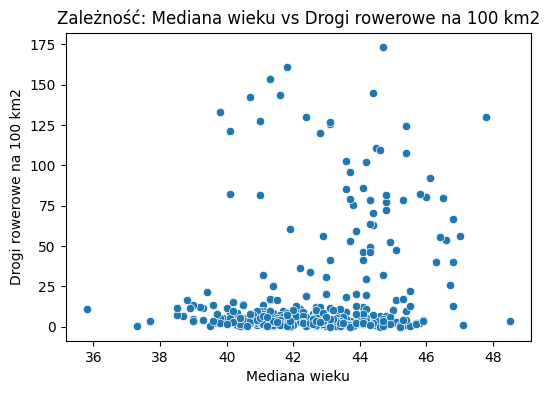

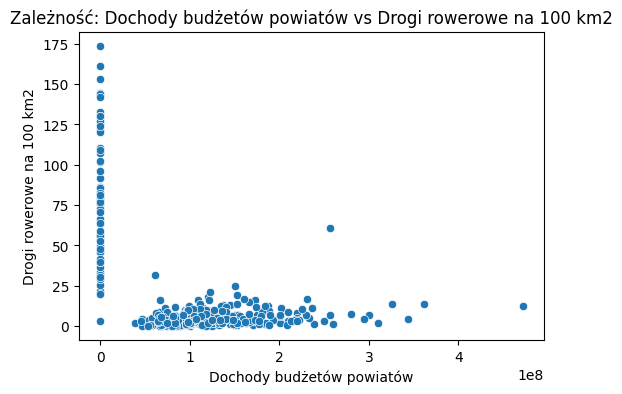

In [71]:
# Wykresy rozrzutu dla każdej zmiennej wejściowej względem zmiennej docelowej
for col in X.columns:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df_selected[col], y=df_selected['Drogi rowerowe na 100 km2'])
    plt.title(f"Zależność: {col} vs Drogi rowerowe na 100 km2")
    plt.xlabel(col)
    plt.ylabel("Drogi rowerowe na 100 km2")
    plt.show()

Wnioski z wykresów zaleźności:

- Brak wyraźnie liniowych zależności – większość wykresów pokazuje dość nieliniowe rozproszenie.
- Najmocniejsze związki (zarówno dodatnie, jak i ujemne) obserwujemy z dochodami powiatów (korelacja –0.54), terenami zieleni (+0.36) i wynagrodzeniami (+0.36).
- Zależności te potwierdzają się z wynikami macierzy korelacji, lecz trzeba pamiętać, że takie wykresy nie świadczą bezpośrednio o przyczynowości – stanowią raczej przegląd tendencji.
- Zmienn aMediana wieku wykazuje najsłabszą zależność z infrastrukturą rowerową w porównaniu z innymi czynnikami.


##### Standaryzacja cech

Standaryzacja zmiennej to proces matematycznego przekształcania danych, w celu uzyskania nowego rozkładu wyników o średniej równej 0 i odchyleniu standardowym równym 1

In [30]:
# Standaryzacja cech (skalowanie)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##### Podział daanych na zbiór uczący i testowy

In [31]:
# Podział danych (70% trening, 15% walidacja, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [32]:
print(f"Rozmiar zbioru treningowego: {X_train.shape}")
print(f"Rozmiar zbioru walidacyjnego: {X_val.shape}")
print(f"Rozmiar zbioru testowego: {X_test.shape}")

Rozmiar zbioru treningowego: (266, 5)
Rozmiar zbioru walidacyjnego: (57, 5)
Rozmiar zbioru testowego: (57, 5)


##### Budowanie modelu sieci neuronowej

In [33]:
# Funkcja budująca model
def build_model(neurons=32, learning_rate=0.001):
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(neurons, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

In [34]:
# Opakowanie modelu w KerasRegressor
model = KerasRegressor(model=build_model, verbose=0)

# Definicja siatki hiperparametrów
param_grid = {
    'model__neurons': [32, 64, 128],
    'model__learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [ ]:
# Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_result = grid.fit(X_train, y_train)

# Wyświetlenie najlepszych parametrów
print(f"Najlepsze parametry: {grid_result.best_params_}")
print(f"Najlepszy wynik (neg-MSE): {grid_result.best_score_:.4f}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\ozime\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ozime\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ozime\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

C:\Users\ozime\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


C:\Users\ozime\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ozime\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ozime\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

Najlepsze parametry: {'batch_size': 32, 'epochs': 100, 'model__learning_rate': 0.01, 'model__neurons': 64}
Najlepszy wynik (neg-MSE): -279.0461


In [36]:
#!pip uninstall -y scikit-learn
#!pip install scikit-learn==1.3.1

In [37]:
# Wyciągnięcie najlepszych hiperparametrów
best_params = grid_result.best_params_
neurons = best_params['model__neurons']
learning_rate = best_params['model__learning_rate']
batch_size = best_params['batch_size']
epochs = best_params['epochs']

In [ ]:
# Trening najlepszego modelu
best_model = build_model(neurons=neurons, learning_rate=learning_rate)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 947.7399 - mae: 13.6985 - val_loss: 1055.6312 - val_mae: 14.4440
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 870.1156 - mae: 15.6440 - val_loss: 734.0073 - val_mae: 18.0610
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 619.7040 - mae: 16.2528 - val_loss: 600.6618 - val_mae: 14.8677
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 547.1279 - mae: 13.7042 - val_loss: 571.7156 - val_mae: 12.0219
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 430.2160 - mae: 11.0044 - val_loss: 480.8290 - val_mae: 11.4041
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 380.7739 - mae: 10.4335 - val_loss: 414.2124 - val_mae: 10.7664
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 373.5576 - mae: 10.9151 - val_loss: 399.4419 - val_mae: 10.5985
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 241.0645 - mae: 8.6158 - val_loss: 375.7679 - val_mae: 10.2969
Epoch 9/100
9/9 ━━━━━━━━

In [ ]:
# Ewaluacja na zbiorze testowym
test_loss, test_mae = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 500.2168 - mae: 12.3513
Test Loss (MSE): 483.6884
Test MAE: 11.8073


##### Wyniki na zbiorze testowym (Sieć neuronowa)

- Funkcja straty (MSE): 483.6884
- Metryka MAE: 11.8073

Oznacza to, że średni błąd kwadratowy (MSE) wynosi ok. 483.7, czyli różnica między wartościami przewidywanymi a rzeczywistymi (podniesiona do kwadratu i uśredniona) to niespełna 484. Średni błąd absolutny (MAE) wynoszący około 11.8 wskazuje, że sieć neuronowa w typowym przypadku „myli się” o ok. 12 jednostek w przewidywaniu „Dróg rowerowych na 100 km2”.

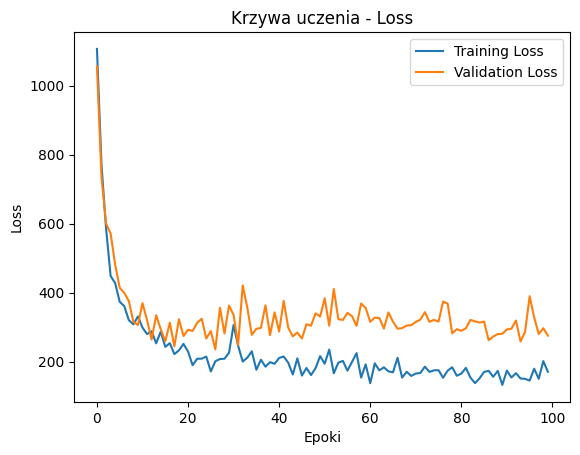

In [ ]:
# Wizualizacja strat
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Krzywa uczenia - Loss')
plt.xlabel('Epoki')
plt.ylabel('Loss')
plt.legend()
plt.show()

Krzywa uczenia – Loss

Etapy początkowe (pierwsze 10 epok)
- Widać gwałtowny spadek zarówno błędu na zbiorze treningowym, jak i walidacyjnym.
- Model uczy się szybko w pierwszych epokach, co jest typowe przy stosowaniu optymalizatorów typu Adam.

Dalsza część treningu (od 10 do 30 epoki)
- Kolejne wahania Lossu, ale wartości nieco się stabilizują.
- Spadek na zbiorze treningowym jest wyraźniejszy niż na walidacyjnym, co może sugerować, że model zaczyna dopasowywać się mocniej do danych treningowych.

Ostateczne kształtowanie się błędu (po 30–40 epoce)
- Widać, że Training Loss pozostaje na niższym poziomie (ok. 100–200 i dalej spada), podczas gdy Validation Loss waha się w szerszym zakresie (z nieco wyższą średnią).
- Te różnice zwykle wskazują na pewien poziom overfittingu (przeuczenia), ale nie jest on duży.

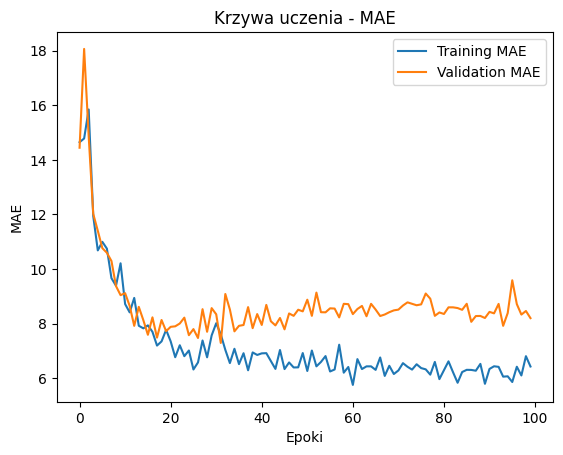

In [ ]:
# Wizualizacja MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Krzywa uczenia - MAE')
plt.xlabel('Epoki')
plt.ylabel('MAE')
plt.legend()
plt.show()

Krzywa uczenia – MAE

Faza początkowa (0–10 epok)
- MAE (Training i Validation) gwałtownie maleje do wartości poniżej 10.
- Oznacza to, że początkowo model znacząco polepsza swoje prognozy.

Stabilizacja (ok. 10–40 epok)
- Widać falowanie wykresu walidacyjnego w zakresie 7–10, podczas gdy treningowy MAE dalej spada.
- Tu też pojawia się delikatne przeuczenie – model na treningu radzi sobie lepiej niż na walidacji.

Końcowa faza (40–100 epok)
- MAE na zbiorze treningowym oscyluje mniej więcej w okolicach 5–7, natomiast walidacyjny jest nieco wyższy (6–9).

##### Wykres SHAP

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  2%|▏         | 1/50 [00:00<00:16,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 2/50 [00:00<00:15,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  6%|▌         | 3/50 [00:00<00:13,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  8%|▊         | 4/50 [00:01<00:13,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 10%|█         | 5/50 [00:01<00:12,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 12%|█▏        | 6/50 [00:01<00:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 14%|█▍        | 7/50 [00:01<00:11,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 16%|█▌        | 8/50 [00:02<00:11,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 18%|█▊        | 9/50 [00:02<00:11,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 20%|██        | 10/50 [00:02<00:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 22%|██▏       | 11/50 [00:03<00:10,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 24%|██▍       | 12/50 [00:03<00:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 26%|██▌       | 13/50 [00:03<00:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 28%|██▊       | 14/50 [00:03<00:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 30%|███       | 15/50 [00:04<00:09,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 32%|███▏      | 16/50 [00:04<00:08,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 34%|███▍      | 17/50 [00:04<00:09,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 36%|███▌      | 18/50 [00:05<00:09,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 38%|███▊      | 19/50 [00:05<00:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 40%|████      | 20/50 [00:05<00:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 42%|████▏     | 21/50 [00:05<00:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 22/50 [00:06<00:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 46%|████▌     | 23/50 [00:06<00:07,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 48%|████▊     | 24/50 [00:06<00:07,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 50%|█████     | 25/50 [00:07<00:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 26/50 [00:07<00:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 54%|█████▍    | 27/50 [00:07<00:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 56%|█████▌    | 28/50 [00:07<00:06,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 29/50 [00:08<00:06,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 60%|██████    | 30/50 [00:08<00:06,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 62%|██████▏   | 31/50 [00:08<00:05,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 32/50 [00:09<00:05,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 66%|██████▌   | 33/50 [00:09<00:05,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 68%|██████▊   | 34/50 [00:09<00:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 35/50 [00:10<00:04,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 72%|███████▏  | 36/50 [00:10<00:04,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 74%|███████▍  | 37/50 [00:10<00:04,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 38/50 [00:10<00:03,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 78%|███████▊  | 39/50 [00:11<00:03,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 80%|████████  | 40/50 [00:11<00:02,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 41/50 [00:11<00:02,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 84%|████████▍ | 42/50 [00:12<00:02,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 43/50 [00:12<00:01,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 88%|████████▊ | 44/50 [00:12<00:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 90%|█████████ | 45/50 [00:12<00:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 92%|█████████▏| 46/50 [00:13<00:01,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 94%|█████████▍| 47/50 [00:13<00:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 96%|█████████▌| 48/50 [00:13<00:00,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 98%|█████████▊| 49/50 [00:14<00:00,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


100%|██████████| 50/50 [00:14<00:00,  3.38it/s]


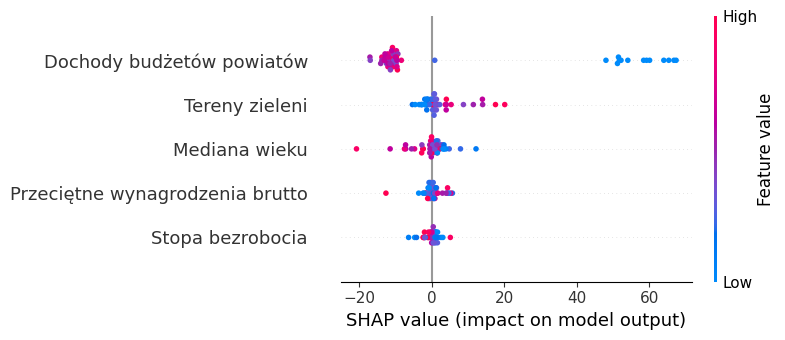

In [ ]:
# Funkcja predykcji:
def nn_predict(data):
    return best_model.predict(data).flatten()

# Próbka do badania
background = X_train[:50]

explainer = shap.KernelExplainer(nn_predict, background)

# Obliczamy shap values na części testowej
shap_values = explainer.shap_values(X_test[:50])

shap.summary_plot(shap_values, X_test[:50], feature_names=X.columns)


##### Wnioski z wykresu:

- Największy wpływ (najszerszy rozrzut wartości SHAP) ma cecha Dochody budżetów powiatów, co wskazuje, że model mocno wykorzystuje tę zmienną do regulowania predykcji.
- Pozostałe cechy (Tereny zieleni, Wynagrodzenia, Bezrobocie) również wnoszą zauważalny wkład – w zależności od kombinacji innych zmiennych ich wpływ bywa dodatni (czerwone punkty z dodatnimi wartościami SHAP) bądź ujemny.

Dzięki SHAP widać, że nie ma jednej prostej reguły, niemniej można zauważyć pewnie wzorce (np. ogólnie wysoka stopa bezrobocia częściej obniża wyniki, a wysokie wynagrodzenia je podwyższają). To potwierdza, że sieć neuronowa traktuje zmienne w sposób wielowymiarowy i nieliniowy.

##### Regresja liniowa

In [42]:
# Regresja liniowa
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Wyniki regresji liniowej
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Regresja liniowa MSE: {mse_lr:.4f}")

Regresja liniowa MSE: 759.7913


Porównanie z innymi modelami

-  MSE sieci neuronowej wynosiło ok. 483.69 (jest niższe), co oznacza, że regresja liniowa generuje wyższy błąd średniokwadratowy i jest mniej skuteczna na tym zbiorze danych.

Znaczenie wartości MSE

- Wartość 759.79 wskazuje, że średni kwadrat błędu predykcji jest wyższy niż w przypadku sieci neuronowej, co sugeruje gorsze dopasowanie w tym konkretnym zadaniu (przewidywanie liczby dróg rowerowych na 100 km²).

Możliwe przyczyny słabszego wyniku

- Regresja liniowa wymaga założenia liniowości między cechami a zmienną docelową. Jak wskazywały wcześniejsze analizy (np. rozkłady i korelacje), zależności mogą być nieliniowe.

Regresja liniowa sprawdziła się gorzej niż bardziej elastyczne modele (np. sieć neuronowa).

##### Las losowy

In [43]:
# Inicjalizacja modelu lasu losowego
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Trenowanie modelu
rf_model.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred_rf = rf_model.predict(X_test)

In [44]:
# Ewaluacja modelu lasu losowego
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Las losowy - MSE: {mse_rf:.4f}")
print(f"Las losowy - MAE: {mae_rf:.4f}")
print(f"Las losowy - R²: {r2_rf:.4f}")

Las losowy - MSE: 362.1247
Las losowy - MAE: 10.5704
Las losowy - R²: 0.7514


Interpretacja

Poziom błędów
- MSE (362.12) jest niższe niż w przypadku regresji liniowej (MSE ~759.79) i sieci neuronowej (MSE ~483.69), co sugeruje, że las losowy lepiej dopasowuje się do danych i trafniej przewiduje liczbę dróg rowerowych na 100 km².
- MAE (0.57) oznacza, że przeciętnie model „myli się” o około 10.6 jednostek w przewidywanej liczbie dróg rowerowych.

Wysokie R² (0.75)
- Współczynnik determinacji ok. 0.75 wskazuje, że model wyjaśnia około 75% zmienności wartości docelowej. W porównaniu z innymi podejściami (np. regresją liniową), jest to wynik dość wysoki.

Las losowy ma umiejętność uchwycenia nieliniowych i złożonych zależności między cechami a zmienną docelową, co jest szczególnie ważne przy skośnych i zróżnicowanych danych dotyczących powiatów.


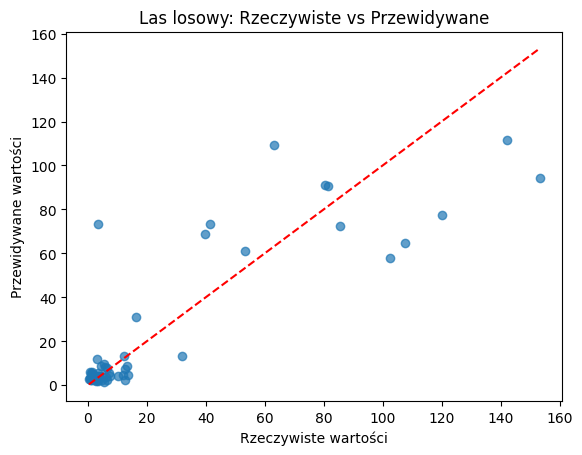

In [ ]:
# Wykres rzeczywiste vs przewidywane dla lasu losowego
plt.scatter(y_test, y_pred_rf, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Las losowy: Rzeczywiste vs Przewidywane")
plt.xlabel("Rzeczywiste wartości")
plt.ylabel("Przewidywane wartości")
plt.show()

In [46]:
# Wyniki regresji liniowej
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

In [ ]:
# Tabela z wynikami
results_table = pd.DataFrame({
    "Model": ["Regresja liniowa", "Las losowy", "Sieć neuronowa"],
    "MSE": [mse_lr, mse_rf, test_loss],
    "MAE": [mae_lr, mae_rf, test_mae],
    "R²": [r2_lr, r2_rf, r2_score(y_test, best_model.predict(X_test))]
})

# Wyświetlenie tabeli
print(results_table)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
              Model         MSE        MAE        R²
0  Regresja liniowa  759.791252  18.993331  0.478379
1        Las losowy  362.124694  10.570363  0.751390
2    Sieć neuronowa  483.688385  11.807320  0.667933


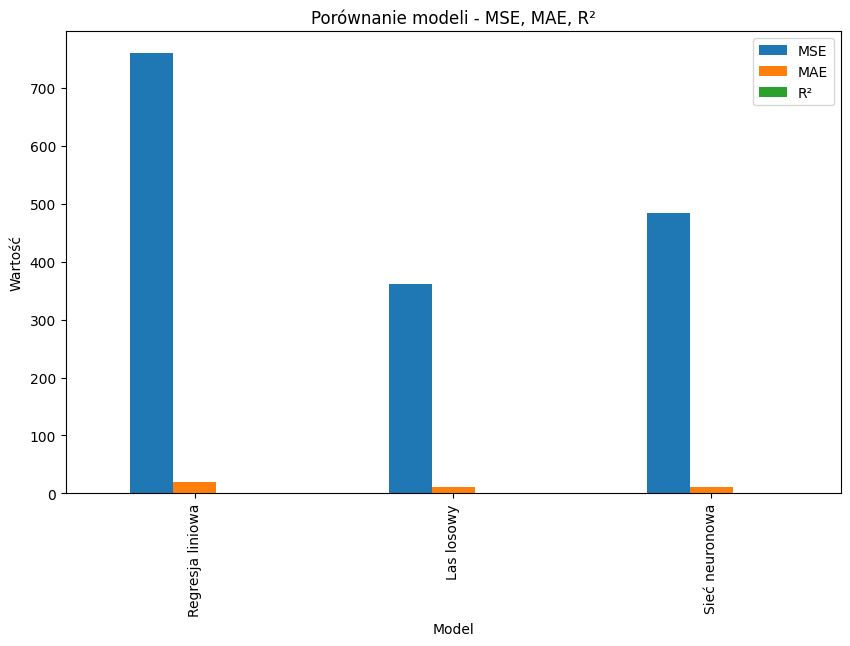

In [ ]:
# Wykres porównawczy dla MSE, MAE i R²
results_table.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Porównanie modeli - MSE, MAE, R²")
plt.ylabel("Wartość")
plt.show()

##### Wnioski

- Najlepszy model: Las losowy (najniższy MSE, najwyższe R²)
- Najgorszy model: Regresja liniowa (najwyższy MSE, najniższe R²)
- Sieć neuronowa plasuje się w środku stawki, radząc sobie wyraźnie lepiej niż regresja liniowa, lecz gorzej niż las losowy.

Wyniki te sugerują, że w przypadku danych o nieliniowych zależnościach, modele nieparametryczne takie jak las losowy radzą sobie szczególnie dobrze. Jednocześnie sieć neuronowa również poprawnie odwzorowuje te dane, a regresja liniowa – ograniczona wymogiem liniowości – nie jest w stanie skutecznie uchwycić złożonych zależności.

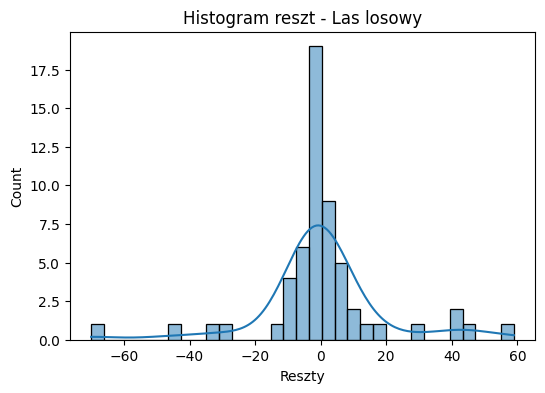

In [ ]:
# Reszty dla lasu losowego
residuals_rf = y_test - y_pred_rf

# Wykres reszt
plt.figure(figsize=(6, 4))
sns.histplot(residuals_rf, kde=True)
plt.title('Histogram reszt - Las losowy')
plt.xlabel('Reszty')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


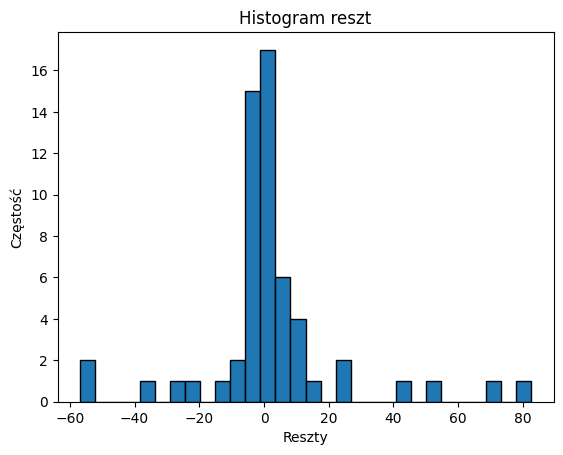

In [ ]:
# Reszty dla najlepszego modelu
residuals = y_test - best_model.predict(X_test).flatten()

# Histogram reszt
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Histogram reszt")
plt.xlabel("Reszty")
plt.ylabel("Częstość")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


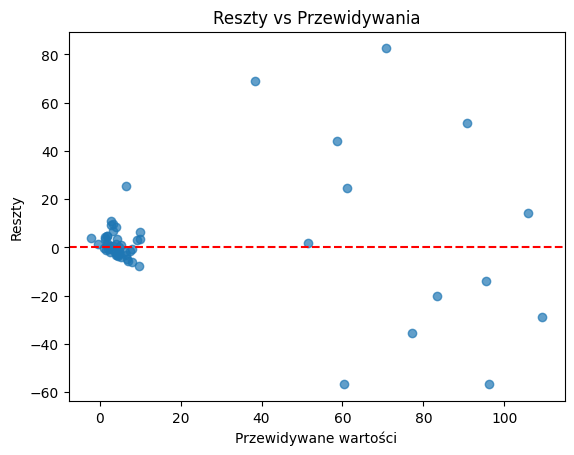

In [ ]:
# Reszty vs przewidywane wartości
plt.scatter(best_model.predict(X_test).flatten(), residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Reszty vs Przewidywania")
plt.xlabel("Przewidywane wartości")
plt.ylabel("Reszty")
plt.show()

##### Wnioski z wykresów reszt

- Większość błędów koncentruje się wokół niewielkich wartości dodatnich i ujemnych, co potwierdza dobrą skuteczność lasu losowego w przewidywaniu liczby dróg rowerowych dla „przeciętnych” powiatów.
- Duże odchylenia wskazują, że w specyficznych regionach (np. o nietypowych cechach lub rzadkich wartościach) model bywa mniej precyzyjny.
- Brak systematycznego trendu w resztach sugeruje, że błędy są raczej rozłożone przypadkowo, co jest dobrym sygnałem w kontekście założeń regresyjnych.

#### Podsumowanie

Celem projektu było przewidzenie liczby dróg rowerowych (na 100 km²) w powiatach. Do tego wykorzystano dane z GUS (m.in. o stopie bezrobocia, wynagrodzeniach, terenach zieleni, medianie wieku i dochodach budżetów powiatów) oraz plik shapefile z granicami powiatów. Ozyszczono dane poprzez uzupełnienie braków medianą, usunięcie wartości odstających (też przez zastąpienie medianą) i zastosowanie skalowania. W analizie rozkładów większość zmiennych wyszła mocno skośnie, co potwierdziły testy Shapiro–Wilka i wizualizacje (histogramy i wykresy Q-Q).

Przetestowano trzy modele: regresję liniową, las losowy i sieć neuronową (Keras). Najlepiej wypadł las losowy – osiągnął najniższe MSE i najwyższe R² (ok. 0,75). Sieć neuronowa była druga z R² ok. 0,67, a regresja liniowa okazała się najsłabsza (R² ~0,48). Dodatkowo użyto SHAP, żeby zobaczyć, które cechy mają największy wpływ na wynik - kluczowe są przede wszystkim dochody budżetów powiatów, a także wynagrodzenia i tereny zieleni. To potwierdza, że w tym zagadnieniu występują zależności nieliniowe, więc bardziej elastyczne metody (las losowy, sieć neuronowa) radzą sobie lepiej niż zwykła regresja liniowa.

Źródła
- materiały z wykładów
- https://github.com/slundberg/shap
- https://www.ibm.com/docs/pl/spss-modeler/saas?topic=nodes-random-forest-node
- https://pogotowiestatystyczne.pl/slowniki/standaryzacja/
- https://portal.geo.stat.gov.pl/
- https://scikit-learn.org/stable/
- https://www.tensorflow.org/api_docs